# 신경망 학습 (MNIST in Pytorch)

In [ ]:
import torch # 파이토치 기본 라이브러리 
import torchvision # 이미지 관련 된 파이토치 라이브러리
from torchvision import datasets # 토치비전에서 제공하는 데이터셋
from torchvision import transforms # 이미지 전처리 기능들을 제공하는 라이브러리
from torch.utils.data import DataLoader # 데이터를 모델에 사용할 수 있도록 적재해 주는 라이브러리
import numpy as np 
import matplotlib.pyplot as plt

## 1. 데이터 불러오기

In [ ]:
# Compose 함수를 통해 원하는 전처리를 차례대로 넣을 수 있음
# transform = transforms.Compose[transforms.Resize(16), transforms.ToTensor()]
# datasets.MNIST("MNIST_data/", download=True, train=True, transform=transform)

In [ ]:
trainset = datasets.MNIST("MNIST_data/", download=True, train=True, transform=transforms.ToTensor())
testset = datasets.MNIST("MNIST_data/", download=True, train=False, transform=transforms.ToTensor())

In [ ]:
print(type(trainset), len(trainset))
print(type(testset), len(testset))

<class 'torchvision.datasets.mnist.MNIST'> 60000
<class 'torchvision.datasets.mnist.MNIST'> 10000


In [ ]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST_data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
type(trainset[0][0]), type(trainset[0][1])

(torch.Tensor, int)

In [ ]:
# trainset[0][0].size() 
# 1 x 28 x 28 : channels x width x height
# 일반적으로(openCV 등에서는) 이미지가 width x height x channels 로 크기가 표현
# 그러나 파이토치에서는 이미지 한장이 channels x width x height 표시됨을 유의
trainset[0][0].size() # trainset[0][0].shape

torch.Size([1, 28, 28])

## 2. 데이터 시각화

In [ ]:
# numpy 이용시
# trainset[0][0].permute(1, 2, 0).numpy().squeeze(axis=2)

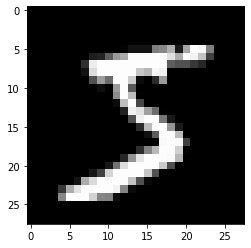

In [ ]:
# tensor 이용시
# for grayscale : 0번 차원을 색인해서 사용
plt.imshow(trainset[0][0][0, :, :], cmap="gray")

In [ ]:
# tensor 이용시
# for color 
# plt.imshow(trainset[0][0].permute(1, 2, 0))

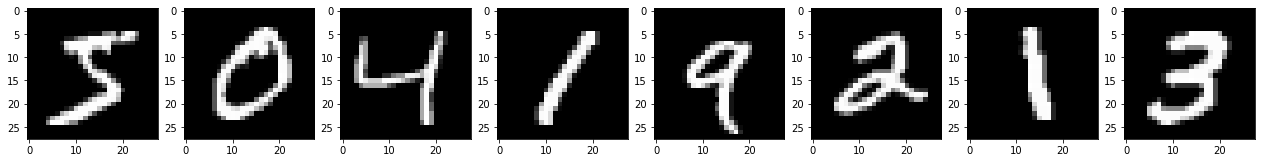

In [ ]:
figure, axes = plt.subplots(figsize=(22, 6), nrows=1, ncols=8)
for i in range(8):
  axes[i].imshow(trainset[i][0][0, :, :], cmap="gray")

## 3. 데이터 적재

In [ ]:
# 파이토치는 데이터를 셔플하거나, 병렬로 데이터를 부르거나,혹은 배치 작업을 
# torch.utils.data.DataLoader 를 통해서 도와줌
bath_size = 100
trainloader = DataLoader(trainset, batch_size=100, shuffle=True) # 훈련용
testloader = DataLoader(testset, batch_size=100, shuffle=False) # 검증용

In [ ]:
print(type(trainloader), len(trainloader))
print(type(testloader), len(testloader))

<class 'torch.utils.data.dataloader.DataLoader'> 600
<class 'torch.utils.data.dataloader.DataLoader'> 100


In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next() # 100개의 image, 100개의 label
print(images.shape, labels.shape)

torch.Size([100, 1, 28, 28]) torch.Size([100])


## 2. 모델 생성

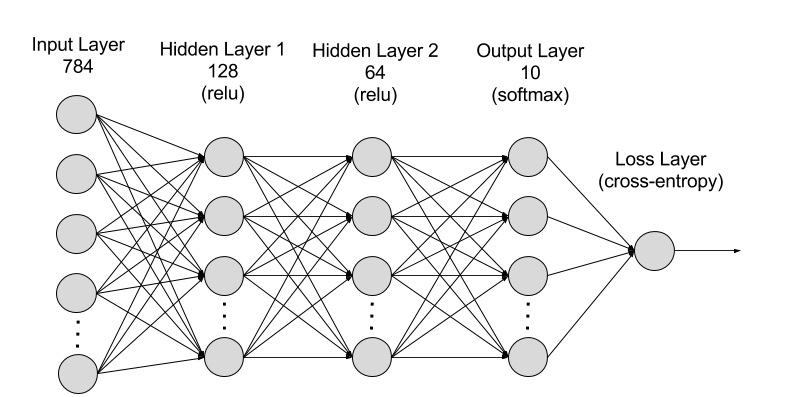

In [ ]:
from torch import nn
from torch import optim
import torch.nn.functional as F

In [ ]:
        # W1 shape (784, 50), B1 shape (50, ), W2 shape (50, 10). B2 shape (10,)
        # a1 = np.dot(x, W1) + b1
        # z1 = sigmoid(a1)
        
        # a2 = np.dot(z1, W2) + b2
        # y = softmax(a2)

In [ ]:
class MnistDNN(nn.Module):
    def __init__(self):
        super().__init__()
        # 계층 정의하기 784(input), 50(hidden), 10(output)
        self.fc1 = nn.Linear(in_features=784, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=10)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
# option1 과 option2는 같은 결과
# option 1
# softmax를 사용하지 않고 crossentropy()

# option 2
# LogSoftmax()를 사용하고 nn.NLLLoss()

#As stated in the torch.nn.CrossEntropyLoss() doc:
#This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
#Therefore, you should not use softmax before.

In [ ]:
model = MnistDNN()
print(model)

MnistDNN(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [ ]:
for parameter in model.parameters():
  print(parameter.size())

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [ ]:
for name, parameter in model.named_parameters():
  print(name, parameter.size())

fc1.weight torch.Size([50, 784])
fc1.bias torch.Size([50])
fc2.weight torch.Size([10, 50])
fc2.bias torch.Size([10])


In [ ]:
from torchsummary import summary

In [ ]:
summary(model, (1, 784))   # (channel , input_size), # 참고: conv layer 입력시 (3, 28, 28)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 50]          39,250
            Linear-2                [-1, 1, 10]             510
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.15
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


In [ ]:
784*50 +50, 50*10+10

(39250, 510)

## 3. 모델 컴파일 (손실함수, 옵티마이저 선택)

In [ ]:
learning_rate = 0.1
criterion = nn.CrossEntropyLoss() # 손실함수
optimizer = optim.SGD(model.parameters(), lr=learning_rate) # 옵티마이저 : SGD()

## 4. 모델 훈련

In [ ]:
epochs = 100
steps = 0
# 1 에폭(epoch)당 반복수
iter_per_epoch = len(trainset) / bath_size  # 600 iterations, len(trainlader)

for e in range(epochs):
  running_loss = 0
  for images, labels in iter(trainloader): #iterator에서 100개씩 가져와 images와 labels에 전달
    steps += 1
    # flatten MNIST images -> 784 벡터
    images.resize_(images.size()[0], 784)
     
    optimizer.zero_grad()

    # 1. Forward (Loss 얻게됨)
    output = model.forward(images)
    loss = criterion(output, labels)

    # 2. Backward (Gradient가 오차역전파로 구해짐)
    loss.backward()

    # 3. Gradient Descent (Model parameter update) :  W <- W-lr*Gradient
    optimizer.step() 

    running_loss += loss.item() # 1 epoch 당 누적된 로스

    if steps % iter_per_epoch == 0 : #600, 1200
      print("Epoch: {}/{}...".format(e+1, epochs),
          "Loss: {}".format(running_loss/iter_per_epoch))
      running_loss = 0


Epoch: 1/100... Loss: 0.529960046261549
Epoch: 2/100... Loss: 0.27743539900829395
Epoch: 3/100... Loss: 0.22426002129912376
Epoch: 4/100... Loss: 0.18912304785102607
Epoch: 5/100... Loss: 0.16397972563902538
Epoch: 6/100... Loss: 0.14496116909508905
Epoch: 7/100... Loss: 0.13044373359531164
Epoch: 8/100... Loss: 0.11864959524944424
Epoch: 9/100... Loss: 0.10909748659158747
Epoch: 10/100... Loss: 0.1005489909928292
Epoch: 11/100... Loss: 0.09347829985121886
Epoch: 12/100... Loss: 0.08744523066406448
Epoch: 13/100... Loss: 0.08240661999521157
Epoch: 14/100... Loss: 0.07724790979952861
Epoch: 15/100... Loss: 0.07375135200563818
Epoch: 16/100... Loss: 0.06985545819314817
Epoch: 17/100... Loss: 0.06624716181773692
Epoch: 18/100... Loss: 0.06376402779327085
Epoch: 19/100... Loss: 0.06059460730214293
Epoch: 20/100... Loss: 0.05793290888890624
Epoch: 21/100... Loss: 0.05537745333975181
Epoch: 22/100... Loss: 0.053221255588966114
Epoch: 23/100... Loss: 0.05126953355424727
Epoch: 24/100... Loss: